In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.8 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split , StratifiedKFold


import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input,Dense, LSTM, RNN, Bidirectional, GlobalAveragePooling2D , Dropout

from transformers import TFAutoModel , AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
class config:
  seed = 43
  train_path = "/content/drive/MyDrive/Social Media Mining/SMM.csv"
  test_path = "/content/drive/MyDrive/Social Media Mining/SMM_test.csv"
  langs = {'Hindi':'hi','Telugu':'te','Marathi':'mr','Tamil':'ta','Malayalam':'ml','Bengali':'bn','Kannada':'kn','Odia':'or','Gujarati':'gu',}
  save_dir = "./result"
  AUTOTUNE = tf.data.AUTOTUNE
  
  #model params
  epochs = 12
  max_len = 64
  batch_size = 128
  hf_path = "google/muril-base-cased" 

def seed_everything(seed = config.seed):
  print(f"seeded everything to seed {seed}")
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

if not os.path.exists(config.save_dir):
  os.makedirs(config.save_dir)
  
seed_everything()

seeded everything to seed 43


In [ ]:
df_train = pd.read_csv(config.train_path)
df_test = pd.read_csv(config.test_path)

In [ ]:
df_train[df_train['language'] == 'Hindi']

,language,post_index,commentText,report_count_comment,report_count_post,like_count_comment,like_count_post,label,val
0,Hindi,238566,शायद योगी जी है,0,0,1,1,0,0
1,Hindi,7009,Tingri h to putri tu.. .,0,0,0,0,0,0
2,Hindi,404648,Saale Tu kon sa pagal Nahi h . Teri comment pa...,0,0,0,0,1,0
3,Hindi,5057,girl 😘😘 aaj ke baad msg ki to maar daluggi,0,0,0,0,0,0
4,Hindi,107146,Free fire pubg ka baap ha kutta sala kamina,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
665037,Hindi,372573,Yr bhai ye launda jahar h...,0,0,1,530,0,0
665038,Hindi,271190,⃢☠︎︎🦅🅡︎ ⃢🅴︎ ⃢🅗︎⃢ 🅰︎🅽︎⑅⃝💜✔︎ koshish kr lo dodne...,0,0,0,0,0,0
665039,Hindi,356484,बेरीनाईस पिक जी 🇮🇳 *🙏 🙏,0,0,0,0,0,0
665040,Hindi,356897,Amit mar do sale ko,0,0,0,0,0,0


In [ ]:
def count(dataframe):
  lengths = []
  for i in tqdm(dataframe['commentText']):
    length = len(i.split(' '))
    lengths.append(length)
  lengths = np.array(lengths)
  print(f"the average length of the excerpts is {np.mean(lengths)}, the median length is {np.median(lengths)} ,  the maxium length is {np.max(lengths)},the maxium length is {np.min(lengths)}")
  return lengths

In [ ]:
lengths = count(df_train)

  0%|          | 0/665042 [00:00<?, ?it/s]

the average length of the excerpts is 12.789882443514845, the median length is 8.0 ,  the maxium length is 5890,the maxium length is 4


<Axes: ylabel='count'>

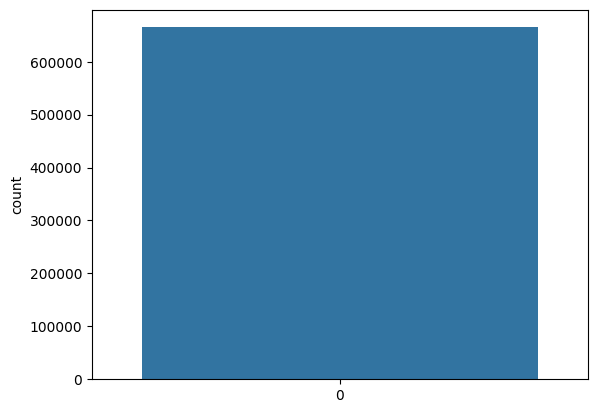

In [ ]:
sns.countplot(lengths)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.hf_path)
tokenizer.save_pretrained(os.path.join(config.save_dir , "muril_tokenizer"))

('./result/muril_tokenizer/tokenizer_config.json',
 './result/muril_tokenizer/special_tokens_map.json',
 './result/muril_tokenizer/vocab.txt',
 './result/muril_tokenizer/added_tokens.json',
 './result/muril_tokenizer/tokenizer.json')

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=512, maxlen=config.max_len):
    
    input_ids = []
    tt_ids = []
    at_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size]
        encs = tokenizer(
                    text_chunk,
                    max_length = config.max_len,
                    padding='max_length',
                    truncation=True
                    )
        
        input_ids.extend(encs['input_ids'])
        tt_ids.extend(encs['token_type_ids'])
        at_ids.extend(encs['attention_mask'])
    
    return {'input_ids': input_ids, 'token_type_ids': tt_ids, 'attention_mask':at_ids}

In [ ]:
token_data = fast_encode(list(df_train['commentText'].values), tokenizer)
token_data['index'] = list(df_train['post_index'].values)
token_data['label'] = list(df_train['label'].values)
token_data['language'] = list(df_train['language'].values)

  0%|          | 0/1299 [00:00<?, ?it/s]

In [ ]:
test_token_data = fast_encode(list(df_test['commentText'].values), tokenizer)
test_token_data['index'] = list(df_test['post_index'].values)
test_token_data['language'] = list(df_test['language'].values)

  0%|          | 0/146 [00:00<?, ?it/s]

In [ ]:
df_tokenized = pd.DataFrame(token_data)

In [ ]:
df_test_tokenized = pd.DataFrame(test_token_data)

In [ ]:
len(df_test_tokenized['input_ids'][0])

64

In [ ]:
@tf.function
def train_prep_function(embeddings , target):
  input_ids = embeddings['input_ids']
  attention_mask = embeddings['attention_mask']

  target = tf.cast(target, tf.int32)
  
  return {'input_ids': input_ids , 'attention_mask': attention_mask}, target

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.32.244.210:8470


REPLICAS:  8


In [ ]:
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import Flatten, LSTM

In [ ]:
def create_model(transformer_model):
  input_id_layer = Input(shape=(config.max_len,) ,dtype = tf.int32 , name = 'input_ids')
  attention_mask_layer = Input(shape=(config.max_len,) , dtype = tf.int32 , name = 'attention_mask')

  transformer = transformer_model(input_ids = input_id_layer , attention_mask = attention_mask_layer)[0]
  transformer_output = transformer[:,0,:]

  bd_layer = BatchNormalization()(transformer)
  x = Dropout(0.1)(bd_layer)
  x1 = tf.keras.layers.Conv1D(1,1)(x)
  x1 = tf.keras.layers.Flatten()(x1)
  bd_layer_1 = BatchNormalization()(x1)
  predictions = Dense(1, activation = "sigmoid")(bd_layer_1)

  model = Model(inputs=[input_id_layer , attention_mask_layer], outputs = predictions)
  model.compile(
      optimizer = Adam(learning_rate= 1e-5),
      metrics = 'accuracy',
      loss = 'binary_crossentropy'
  )

  return model
  

In [ ]:
with strategy.scope():
  transformer_model = TFAutoModel.from_pretrained(config.hf_path)
  model = create_model(transformer_model)
model.summary()

Some layers from the model checkpoint at google/muril-base-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  237556224   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

In [ ]:
df_tokenized.head()

,input_ids,token_type_ids,attention_mask,index,label,language
0,"[104, 10478, 14318, 2254, 1115, 105, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",238566,0,Hindi
1,"[104, 116969, 101565, 179, 1113, 48907, 1206, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",7009,0,Hindi
2,"[104, 87541, 9535, 94108, 1278, 1274, 14604, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",404648,1,Hindi
3,"[104, 7313, 100, 4430, 1159, 3032, 95948, 2003...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5057,0,Hindi
4,"[104, 9480, 6985, 81441, 2003, 25124, 60885, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",107146,1,Hindi


In [ ]:
df_tokenized_label = df_tokenized['label']
df_tokenized = df_tokenized.drop(columns=['label'])

In [ ]:
y_test = [0 for i in range(df_test_tokenized.shape[0])]

In [ ]:
len(y_test)

74253

In [ ]:
test_embeddings = {'input_ids': df_test_tokenized['input_ids'].tolist() ,"attention_mask":df_test_tokenized['attention_mask'].tolist()}
test_data = tf.data.Dataset.from_tensor_slices((test_embeddings, y_test))
test_data = (
    test_data
    .map(train_prep_function , num_parallel_calls = config.AUTOTUNE)
    .batch(config.batch_size)
    .prefetch(config.AUTOTUNE)
)

In [ ]:
scores = []
hists = []
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(df_tokenized, df_tokenized_label, test_size=0.1,random_state=123)
train_embeddings = {'input_ids': x_train['input_ids'].tolist() ,"attention_mask":x_train['attention_mask'].tolist()}
test_embeddings = {'input_ids': x_val['input_ids'].tolist() ,"attention_mask":x_val['attention_mask'].tolist()}
y_train = y_train.tolist()
y_val = y_val.tolist()
train_steps = len(train_embeddings['input_ids'])//config.batch_size//4
validation_steps = len(test_embeddings['input_ids'])//config.batch_size
print(f"training steps {train_steps} , validation steps {validation_steps}")
train_dataset = tf.data.Dataset.from_tensor_slices((train_embeddings , y_train))
train_dataset = (
    train_dataset
    .shuffle(1024*2)
    .map(train_prep_function , num_parallel_calls = config.AUTOTUNE)
    .repeat()
    .batch(config.batch_size)
    .prefetch(config.AUTOTUNE)
)
test_dataset = tf.data.Dataset.from_tensor_slices((test_embeddings , y_val ))
test_dataset = (
    test_dataset
    .map(train_prep_function , num_parallel_calls = config.AUTOTUNE)
    .batch(config.batch_size)
    .prefetch(config.AUTOTUNE)
)

hist = model.fit(train_dataset,steps_per_epoch= train_steps,validation_data= test_dataset, epochs = config.epochs)


training steps 1169 , validation steps 519
Epoch 1/12


/usr/local/lib/python3.9/dist-packages/tensorflow/python/framework/indexed_slices.py:459: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 151514880 elements. This may consume a large amount of memory.
  warnings.warn(


1169/1169 [==============================] - 254s 151ms/step - loss: 0.5079 - accuracy: 0.7516 - val_loss: 0.3828 - val_accuracy: 0.8383
Epoch 2/12
1169/1169 [==============================] - 163s 139ms/step - loss: 0.3985 - accuracy: 0.8330 - val_loss: 0.3557 - val_accuracy: 0.8560
Epoch 3/12
1169/1169 [==============================] - 163s 139ms/step - loss: 0.3775 - accuracy: 0.8454 - val_loss: 0.3500 - val_accuracy: 0.8590
Epoch 4/12
1169/1169 [==============================] - 163s 139ms/step - loss: 0.3713 - accuracy: 0.8494 - val_loss: 0.3338 - val_accuracy: 0.8644
Epoch 5/12
1169/1169 [==============================] - 162s 139ms/step - loss: 0.3536 - accuracy: 0.8577 - val_loss: 0.3334 - val_accuracy: 0.8666
Epoch 6/12
1169/1169 [==============================] - 162s 138ms/step - loss: 0.3461 - accuracy: 0.8616 - val_loss: 0.3331 - val_accuracy: 0.8672
Epoch 7/12
1169/1169 [==============================] - 162s 138ms/step - loss: 0.3420 - accuracy: 0.8640 - val_loss: 0.348

In [ ]:
y_orig = model.predict(test_data , verbose = 1)

581/581 [==============================] - 29s 42ms/step


In [ ]:
df_test_tokenized.head()

,input_ids,token_type_ids,attention_mask,index,language
0,"[104, 153045, 115689, 3238, 1213, 91012, 41467...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",182442,Bengali
1,"[104, 100, 54734, 25124, 5253, 105, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",406921,Hindi
2,"[104, 183195, 3096, 9911, 1527, 185, 179, 105,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",233255,Hindi
3,"[104, 63936, 130209, 31551, 139532, 24518, 136...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",219308,Telugu
4,"[104, 187486, 182, 3195, 1159, 29165, 53681, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",269812,Hindi


In [ ]:
submid = pd.DataFrame({'Id': df_test["Id"]})
submission = pd.concat([submid, pd.DataFrame(y_orig, columns = ['Expected'])], axis=1)
submission['Expected'] = submission['Expected'].round().astype(int)
submission = submission.sort_values(by=['Id'])
submission.to_csv('submission.csv', index=False)

In [ ]:
submission['Expected'].value_counts()

0    40577
1    33676
Name: Expected, dtype: int64

In [ ]:
y_orig = model.predict(test_dataset , verbose = 1)
score = roc_auc_score(y_val ,y_orig)
print(score)

520/520 [==============================] - 20s 36ms/step
0.9348276239624328


In [ ]:
import copy
y_predict = copy.deepcopy(y_orig)

In [ ]:
submid = pd.DataFrame({'language':x_val['language'].tolist(), 'label':y_val})
submid = pd.concat([submid, pd.DataFrame(y_predict, columns = ['predicted'])], axis=1)

In [ ]:
submid['predicted'] = submid['predicted'].round()

In [ ]:
from sklearn.metrics import classification_report
print('Classification report for Validation dataset')
print(classification_report(submid['predicted'], submid['label'], target_names=['Non-Abusive','Abusive']))

Classification report for Validation dataset
              precision    recall  f1-score   support

 Non-Abusive       0.89      0.87      0.88     36310
     Abusive       0.85      0.88      0.86     30195

    accuracy                           0.87     66505
   macro avg       0.87      0.87      0.87     66505
weighted avg       0.87      0.87      0.87     66505



In [ ]:
from sklearn.metrics import classification_report
print('Classification report for Validation dataset of Hindi Langauage')
print(classification_report(submid[submid['language']=='Hindi']['predicted'], submid[submid['language']=='Hindi']['label'], target_names=['Non-Abusive','Abusive']))

Classification report for Validation dataset of Hindi Langauage
              precision    recall  f1-score   support

 Non-Abusive       0.87      0.87      0.87     15361
     Abusive       0.87      0.87      0.87     15488

    accuracy                           0.87     30849
   macro avg       0.87      0.87      0.87     30849
weighted avg       0.87      0.87      0.87     30849



In [ ]:
from sklearn.metrics import classification_report
print('Classification report for Validation dataset of Telugu Langauage')
print(classification_report(submid[submid['language']=='Telugu']['predicted'], submid[submid['language']=='Telugu']['label'], target_names=['Non-Abusive','Abusive']))

Classification report for Validation dataset of Telugu Langauage
              precision    recall  f1-score   support

 Non-Abusive       0.94      0.84      0.89      5445
     Abusive       0.82      0.93      0.87      4224

    accuracy                           0.88      9669
   macro avg       0.88      0.89      0.88      9669
weighted avg       0.89      0.88      0.88      9669



In [ ]:
print('Classification report for Validation dataset of Assamese Langauage')
print(classification_report(submid[submid['language']=='Assamese']['predicted'], submid[submid['language']=='Assamese']['label'], target_names=['Non-Abusive','Abusive']))

Classification report for Validation dataset of Assamese Langauage
              precision    recall  f1-score   support

 Non-Abusive       0.89      0.84      0.86       135
     Abusive       0.79      0.85      0.82        95

    accuracy                           0.84       230
   macro avg       0.84      0.84      0.84       230
weighted avg       0.85      0.84      0.84       230



In [ ]:
print('Classification report for Validation dataset of Rajasthani Langauage')
print(classification_report(submid[submid['language']=='Rajasthani']['predicted'], submid[submid['language']=='Rajasthani']['label'], target_names=['Non-Abusive','Abusive']))

Classification report for Validation dataset of Rajasthani Langauage
              precision    recall  f1-score   support

 Non-Abusive       0.91      0.85      0.88       225
     Abusive       0.86      0.92      0.89       226

    accuracy                           0.88       451
   macro avg       0.88      0.88      0.88       451
weighted avg       0.88      0.88      0.88       451



In [ ]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

520/520 [==============================] - 17s 31ms/step - loss: 0.3230 - accuracy: 0.8719


{'loss': 0.3229714334011078, 'accuracy': 0.8719043731689453}